In [1]:
# import
import bilby 
from gwpy.timeseries import TimeSeries
from scipy import stats
from bilby.core.prior import  Uniform, Interped
import numpy as np
import matplotlib.pyplot as plt
from bilby.core.prior import  LogUniform
from scipy import interpolate
import inspect
from scipy.signal import find_peaks_cwt
from scipy import signal
import gwpy
from bilby.core.utils import infer_parameters_from_function

from context import tbilby

In [2]:
# some settings 
label='tBiliby_ASD_GW150914'

trigger_time = 1126259462.4
maximum_frequency = 896
minimum_frequency = 20
roll_off = 0.4  
duration = 4  # Analysis segment duration
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration
det='H1'

In [4]:

# define some functions to help out  
def get_GW_data(f_i,f_f,median=False):
    
    global minimum_frequency
    global maximum_frequency
    global duration
    global det 
    
    if minimum_frequency < f_i:
        minimum_frequency = f_i 
    if maximum_frequency > f_f:
        maximum_frequency = f_f
    
    
    if median:
        psd_duration = 32 * duration
    else:
        psd_duration = duration 
        
    psd_start_time = start_time - psd_duration
    psd_end_time = start_time
       
    psd_data = gwpy.timeseries.TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time)    
    psd_alpha = 2 * roll_off / duration
    psd = psd_data.psd(
        fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median"
    )
  
    psd_frequencies = psd.frequencies.value
    psd = psd.value
    I = (psd_frequencies > minimum_frequency) &  (psd_frequencies < maximum_frequency)         
    return psd_frequencies[I],np.sqrt(psd[I])


def max_rolling(a, window,axis =1):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return np.max(rolling,axis=axis)
    
def min_rolling(a, window,axis =1):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return np.min(rolling,axis=axis)

def med_rolling(a, window,axis =1):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return np.median(rolling,axis=axis)     
    
    
def find_indices(larger_array, smaller_array):
    indices = []
    for item in smaller_array:
        try:
            index = np.where(larger_array == item)[0][0]
            indices.append(index)
        except IndexError:
            pass
    return indices
# load the data


def create_peaks_prior(x,y):

    arr = np.zeros(x.shape)
    arr_new = np.zeros((2*x.shape[0],))
    dx = x[1]-x[0]
    x_new = np.arange(x[0],x[-1]+dx,0.5*dx)
    y_med = med_rolling(y, 101)
    sigmas = np.arange(6,2.0,-0.5)
    for sigma in sigmas:
        I = y[50:-50] > y_med*sigma
        arr[50:-50][I] += 1

    x_old_inx = arr > 0
    x_vals = x[x_old_inx]
    x_old_inx = np.where(x_old_inx)[0]
    for x_v,x_i in zip(x_vals,x_old_inx):
        difference_array = np.absolute(x_new-x_v)

# find the index of minimum element from the array
        index = difference_array.argmin()
        arr_new[index] = arr[x_i]
        arr_new[index+1] = arr[x_i]
        arr_new[index-1] = arr[x_i]

    plt.plot(x,arr)
    plt.plot(x_new,arr_new,'o')

    return x_new,arr_new


In [9]:
# define some tbilby conditional priors

class TransdimensionalConditionalBeta_Amp(tbilby.core.prior.TransdimensionalConditionalBeta):
 
    def set_extra_data(self,x,y):
        self.y=y
        self.x=x 
        # build interpolation map x-> min, x-> max 
        y_max = max_rolling(y,20)
        y_min = min_rolling(y,20)
        y_med = med_rolling(y,101)
        self.fdata = interpolate.interp1d(x, self.y*1.05,fill_value="extrapolate")
        self.fmin = interpolate.interp1d(x[10:-9], y_min,fill_value="extrapolate")
        self.fmax = interpolate.interp1d(x[50:-50], y[50:-50] - y_med,fill_value="extrapolate")
            
        self.Nsigma = 2 # for now let be conservative 
    
       
    # this uses the full power of the conditional priror, it is based on the smooth function evaluation and teh location of the line       
    # we check if the data's amplitude is large enuogh to account for a line.   
    def transdimensional_condition_function(self,**required_variables):        
            componant_function_number= len(self.Amp)            
            #extract its location 
            x_val = self.loc[componant_function_number]
        
            if isinstance(x_val, float):
                x_val=[x_val]
                
            minimum = self.fmin(x_val) 
            maximum = self.fmax(x_val)
            maximum_data = self.fdata(x_val)
            
            est_smooth_func=np.zeros(np.array(x_val).shape)
            for n in np.arange(np.max(np.max(self.n_exp)).astype(int)):
                est_smooth_func += (self.n_exp > n).astype(float)*exp(x_val,self.A[n],self.lamda[n])   
            
            
            new_minimum = est_smooth_func * self.Nsigma           
            minimum = est_smooth_func * (self.Nsigma-1) # at least the number of sigmas from the smooth fit                          
            maximum  = maximum_data - est_smooth_func
            
            if isinstance(new_minimum,np.ndarray):
                too_big_in_japan =  new_minimum > maximum_data
                minimum[too_big_in_japan] = 0.9
                maximum[too_big_in_japan] = 1
            else: # float 
                if isinstance(new_minimum,(float,np.floating)): 
                    if  new_minimum > maximum_data:
                        maximum = np.array([1])
                        minimum = np.array([0.9])               
            if len(minimum)==1:
                minimum=minimum[0]
                maximum=maximum[0]

                
            return dict(minimum=minimum,maximum=maximum)
        
# actually, here this is not necessary, since we are not doing anything special.. a normal interpolation would work just as well          
class TransdimensionalConditionalTransInterped_loc(tbilby.core.prior.TransdimensionalConditionalTransInterped):
    def transdimensional_condition_function(self,**required_variables):
        # setting the mimmum according the the last peak value
            trans_min = self.minimum
            trans_max = self.maximum
            return dict(trans_min=trans_min,trans_max=trans_max) 
            
    
class TransdimensionalConditionalUniform_lamda(tbilby.core.prior.TransdimensionalConditionalUniform):   
    def transdimensional_condition_function(self,**required_variables):
        # setting the mimmum according the the last peak value
            minimum = self.minimum
            if(len(self.lamda)>0): # handle the first mu case
                minimum = self.lamda[-1] # set the minimum to be the location of the last peak 
                           
            return dict(minimum=minimum)


In [5]:
# define the model functions

def exp(x,A,lamda):  
    xfunc = x.copy() 
    return A*np.power(xfunc,lamda)


def lorentzian(x, loc, Amp, gam):
    # damped tails lorentzian, following bayeslines
    decay =1
    damped_alpha = np.zeros(x.shape) 
    df_i = loc/50
    I_left_tail = x < loc - df_i
    I_right_tail =x > loc + df_i   
    damped_alpha [I_right_tail | I_left_tail] = decay 
    return np.exp(-damped_alpha*(x-df_i)/(df_i)) *Amp * gam**2 / ( gam**2 + ( x - loc )**2)

In [6]:
#define the likelihood function 
class ASD_GaussianLikelihood(bilby.Likelihood):
    def __init__(self, x, y, function):
        
        self.x = x
        self.y = y
        self.N = len(x)

        self.function = function

        # These lines of code infer the parameters from the provided function
        parameters = inspect.getfullargspec(function).args

        del parameters[0]
        super().__init__(parameters=dict.fromkeys(parameters))
        self.parameters = dict.fromkeys(parameters)

        self.function_keys = self.parameters.keys()    
        if 'sigma' in self.function_keys: # remove sigma from function keys otherwise it get sent to the model
           self.function_keys.pop['sigma']
           print('Removing sigma')
    
    def log_likelihood(self):
        model_parameters = {k: self.parameters[k] for k in self.function_keys if k != 'sigma'}        
        est_asd = self.function(self.x, **model_parameters)             
        log_l = -len(est_asd)*np.log(2*np.pi)/2 + np.sum(-0.5*(self.y/est_asd)**2 -np.log(est_asd))       
        return log_l 

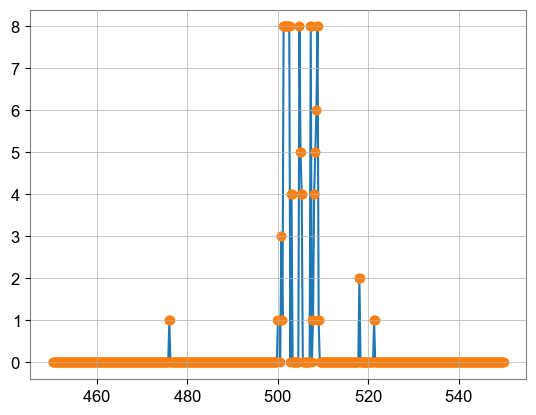

In [7]:
# pre-processing to reduce priro volume and save some time 
# some helper function 
def find_indices(larger_array, smaller_array):
    indices = []
    for item in smaller_array:
        try:
            index = np.where(larger_array == item)[0][0]
            indices.append(index)
        except IndexError:
            pass
    return indices
# load the data 
x,y= get_GW_data(f_i=400,f_f=600)
# find the line with excess power wrt the smooth function which is estimated by the median

xx,yy =create_peaks_prior(x,y)



In [10]:


n_exp=5
n_peaks=12

componant_functions_dict={}
componant_functions_dict[exp]=(n_exp,'A','lamda')
componant_functions_dict[lorentzian]=(n_peaks,'loc', 'Amp', 'gam')

model = tbilby.create_transdimensional_model('model',  componant_functions_dict,returns_polarization=False,SaveTofile=False)

priors_t = bilby.core.prior.dict.ConditionalPriorDict()
# define the smooth function related priors 
priors_t['n_exp'] = tbilby.DiscreteUniform(1,n_exp,'n_exp')
priors_t  = tbilby.create_plain_priors(LogUniform,'A',n_exp,prior_dict_to_add=priors_t,minimum=1e-30, maximum=1e-13)  
priors_t = tbilby.create_transdimensional_priors(TransdimensionalConditionalUniform_lamda,'lamda',nmax=n_exp,nested_conditional_transdimensional_params=['lamda'],conditional_params=[],prior_dict_to_add=priors_t,minimum=-10,maximum=2)
# define the line functions related priors 
priors_t['n_lorentzian'] = tbilby.DiscreteUniform(0,n_peaks,'n_lorentzian')
priors_t = tbilby.create_plain_priors(LogUniform,'gam',n_peaks,prior_dict_to_add=priors_t,minimum=0.01, maximum=1)  
priors_t = tbilby.create_transdimensional_priors(TransdimensionalConditionalTransInterped_loc,'loc',nmax=n_peaks,nested_conditional_transdimensional_params=['loc'],conditional_params=['n_lorentzian'],prior_dict_to_add=priors_t,xx=xx,yy=yy,SaveConditionFunctionsToFile=False)
priors_t_temp = tbilby.create_transdimensional_priors(TransdimensionalConditionalBeta_Amp,'Amp',nmax=n_peaks,nested_conditional_transdimensional_params=['Amp'],conditional_transdimensional_params=['loc',{'A':n_exp,'lamda':n_exp}],conditional_params=['n_exp'],SaveConditionFunctionsToFile=True,alpha = 4, beta=0.2,minimum=10,maximum=1000)
#Here we utilize another flexibility of the tbilby inheritance concept: sending in some data into the prior. 
for k in priors_t_temp.keys():
    priors_t_temp[k].set_extra_data(x,y)    
    priors_t[k] = priors_t_temp[k] # set the priors accordingly 
    
    

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'np', 'pd', 'infer_parameters_from_function', 'bilby', 'DiscreteUniform', 'create_transdimensional_priors', '_create_priors_with_nested_condition_functions', 'create_transdimensional_model', 'create_plain_priors', 'extract_maximal_likelihood_param_values', '_fix_posterior_if_needed', 'preprocess_results', '_recluster_one_dim_posterior_experimental_use_it_wisely', '_group_params_by_numerical_ending', 'exp', 'lorentzian'])
Supplied PDF for loc0 is not normalised, normalising.
Supplied PDF for loc1 is not normalised, normalising.
Supplied PDF for loc2 is not normalised, normalising.
Supplied PDF for loc3 is not normalised, normalising.
Supplied PDF for loc4 is not normalised, normalising.
Supplied PDF for loc5 is not normalised, normalising.
Supplied PDF for loc6 is not normalised, normalising.
Supplied PDF for loc7 is not normalised, normalising.
Supplied PDF for loc8 is n

In [ ]:
x,y= get_GW_data(f_i=400,f_f=600)

likelihood = ASD_GaussianLikelihood(x, y, model)


result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors_t,
        sample='rslice',
        nlive=1000,
        walks=150,
        nact=50,
        outdir='outdir',
        label=label,
        clean=True,
        resume=False,
        npool=16,
        )

Supplied PDF for loc0 is not normalised, normalising.
Supplied PDF for loc1 is not normalised, normalising.
Supplied PDF for loc2 is not normalised, normalising.
Supplied PDF for loc3 is not normalised, normalising.
Supplied PDF for loc4 is not normalised, normalising.
Supplied PDF for loc5 is not normalised, normalising.
Supplied PDF for loc6 is not normalised, normalising.
Supplied PDF for loc7 is not normalised, normalising.
Supplied PDF for loc8 is not normalised, normalising.
Supplied PDF for loc9 is not normalised, normalising.
Supplied PDF for loc10 is not normalised, normalising.
Supplied PDF for loc11 is not normalised, normalising.
grouping by the discrete parameters
n_exp  n_lorentzian
4.0    7.0             2181
2.0    7.0              872
       8.0              591
       6.0              510
       12.0             449
3.0    7.0              340
2.0    9.0              329
3.0    8.0              237
4.0    8.0              190
3.0    9.0              114
2.0    10.0   

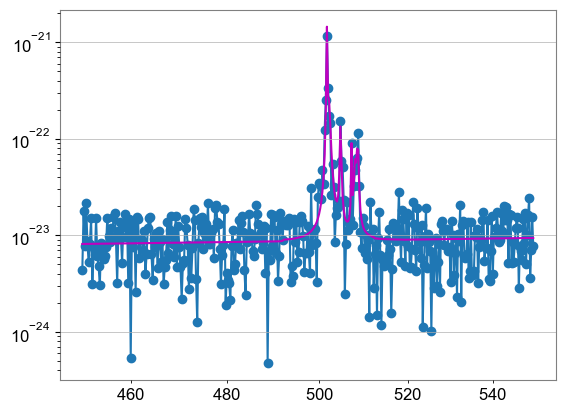

In [11]:
#plot the results 

result = bilby.result.read_in_result(filename=label+'_result.json')
result_processed,cols = tbilby.core.base.preprocess_results(result,componant_functions_dict,remove_ghost_samples=False,return_samples_of_most_freq_component_function=True)
best_params_post = tbilby.core.base.extract_maximal_likelihood_param_values(result_processed, model)
print(best_params_post)
needed_params = infer_parameters_from_function(model)

model_parameters = {k: best_params_post[k] for k in needed_params}

plt.loglog(x,y,'-o',label='Data')
plt.loglog(x,model(x,**model_parameters),'-m',label='Max likelihhod curve')

